In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F
#from backbone import ResNet50
import math
import torch.utils.model_zoo as model_zoo

# ResNet50

In [6]:
__all__ = ['ResNet', 'resnet50']

model_urls = {
    'resnet50': 'https://download.pytorch.org/models/resnet50-19c8e357.pth',

}


def conv3x3(in_planes, out_planes, stride=1):
    """3x3 convolution with padding"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=1, bias=False)


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, inplanes, planes, stride=1, downsample=None, rate=1):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(inplanes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride,
                               padding=rate, dilation=rate, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, planes * self.expansion, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(planes * self.expansion)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out

class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes=1000):
        self.inplanes = 64
        super(ResNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3,
                               bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)

        rates = [1, 2, 4]
        self.layer4 = self._make_deeplabv3_layer(block, 512, layers[3], rates=rates, stride=1)  # stride 2 => stride 1
        self.avgpool = nn.AvgPool2d(7, stride=1)
        self.fc = nn.Linear(512 * block.expansion, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)

    def _make_deeplabv3_layer(self, block, planes, blocks, rates, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes, rate=rates[i]))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)

        return x

def resnet50(pretrained=False, **kwargs):
    """Constructs a ResNet-50 model.

    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
    """
    model = ResNet(Bottleneck, [3, 4, 6, 3], **kwargs)
    if pretrained:
        model.load_state_dict(model_zoo.load_url(model_urls['resnet50']))
    return model

In [7]:
class ResNet50(nn.Module):
    def __init__(self, pretrained=True):
        """Declare all needed layers."""
        super(ResNet50, self).__init__()
        self.model = resnet50(pretrained=pretrained)
        self.relu = self.model.relu  # Place a hook

        layers_cfg = [4, 5, 6, 7]
        self.blocks = []
        for i, num_this_layer in enumerate(layers_cfg):
            self.blocks.append(list(self.model.children())[num_this_layer])

    def base_forward(self, x):
        feature_map = []
        x = self.model.conv1(x);print('resnet50 conv1 shape:', x.shape)
        x = self.model.bn1(x);print('resnet50 bn1 shape:', x.shape)
        x = self.model.relu(x);print('resnet50 relu shape:', x.shape)
        x = self.model.maxpool(x);print('resnet50 maxpool shape:', x.shape)

        for i, block in enumerate(self.blocks):
            x = block(x)
            feature_map.append(x)
        print("feature map len:", len(feature_map))
        # feature map != out
        out = nn.AvgPool2d(x.shape[2:])(x).view(x.shape[0], -1)

        return feature_map, out

# DANet

## Position Attention

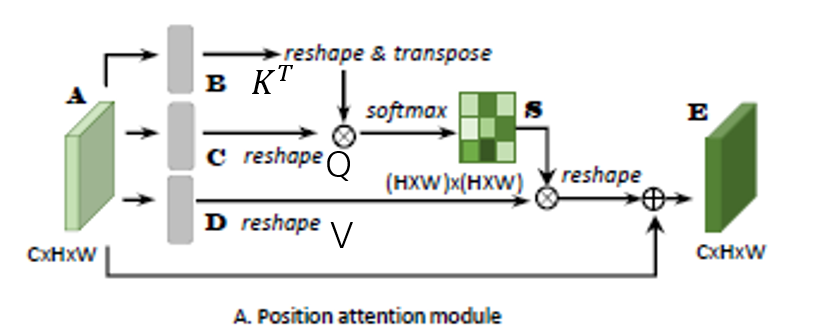

In [8]:
class _PositionAttentionModule(nn.Module):
    """ Position attention module"""

    def __init__(self, in_channels, **kwargs):
        super(_PositionAttentionModule, self).__init__()
        self.conv_b = nn.Conv2d(in_channels, in_channels // 8, 1)
        self.conv_c = nn.Conv2d(in_channels, in_channels // 8, 1)
        self.conv_d = nn.Conv2d(in_channels, in_channels, 1)
        self.alpha = nn.Parameter(torch.zeros(1))
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, x):
        batch_size, _, height, width = x.size()
        feat_b = self.conv_b(x).view(batch_size, -1, height * width).permute(0, 2, 1)
        feat_c = self.conv_c(x).view(batch_size, -1, height * width)
        attention_s = self.softmax(torch.bmm(feat_b, feat_c))
        feat_d = self.conv_d(x).view(batch_size, -1, height * width)
        feat_e = torch.bmm(feat_d, attention_s.permute(0, 2, 1)).view(batch_size, -1, height, width)
        out = self.alpha * feat_e + x

        return out

## Channel Attention

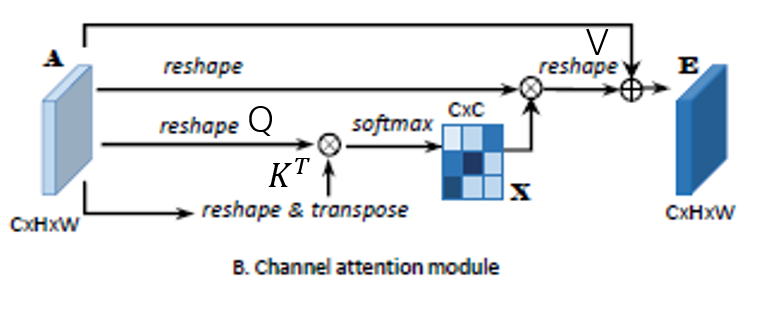

In [9]:
class _ChannelAttentionModule(nn.Module):
    """Channel attention module"""

    def __init__(self, **kwargs):
        super(_ChannelAttentionModule, self).__init__()
        self.beta = nn.Parameter(torch.zeros(1))
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, x):
        batch_size, _, height, width = x.size()
        feat_a = x.view(batch_size, -1, height * width)
        feat_a_transpose = x.view(batch_size, -1, height * width).permute(0, 2, 1)
        attention = torch.bmm(feat_a, feat_a_transpose)
        attention_new = torch.max(attention, dim=-1, keepdim=True)[0].expand_as(attention) - attention
        attention = self.softmax(attention_new)

        feat_e = torch.bmm(attention, feat_a).view(batch_size, -1, height, width)
        out = self.beta * feat_e + x

        return out

## DAHead

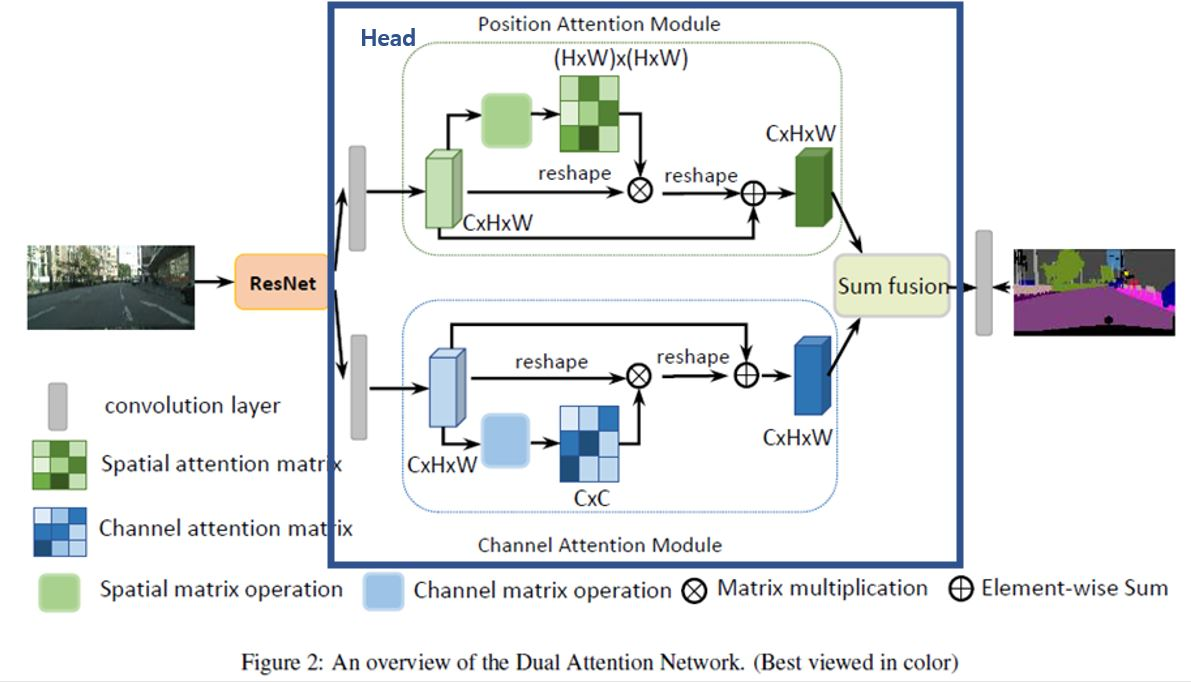

In [16]:
class _DAHead(nn.Module):
    def __init__(self, in_channels, nclass, aux=True, norm_layer=nn.BatchNorm2d, norm_kwargs=None, **kwargs):
        super(_DAHead, self).__init__()
        self.aux = aux
        inter_channels = in_channels // 4
        self.conv_p1 = nn.Sequential(
            nn.Conv2d(in_channels, inter_channels, 3, padding=1, bias=False),
            norm_layer(inter_channels, **({} if norm_kwargs is None else norm_kwargs)),
            nn.ReLU(True)
        )
        self.conv_c1 = nn.Sequential(
            nn.Conv2d(in_channels, inter_channels, 3, padding=1, bias=False),
            norm_layer(inter_channels, **({} if norm_kwargs is None else norm_kwargs)),
            nn.ReLU(True)
        )
        self.pam = _PositionAttentionModule(inter_channels, **kwargs)
        self.cam = _ChannelAttentionModule(**kwargs)
        self.conv_p2 = nn.Sequential(
            nn.Conv2d(inter_channels, inter_channels, 3, padding=1, bias=False),
            norm_layer(inter_channels, **({} if norm_kwargs is None else norm_kwargs)),
            nn.ReLU(True)
        )
        self.conv_c2 = nn.Sequential(
            nn.Conv2d(inter_channels, inter_channels, 3, padding=1, bias=False),
            norm_layer(inter_channels, **({} if norm_kwargs is None else norm_kwargs)),
            nn.ReLU(True)
        )
        self.out = nn.Sequential(
            nn.Dropout(0.1),
            nn.Conv2d(inter_channels, nclass, 1)
        )
        if aux:
            self.conv_p3 = nn.Sequential(
                nn.Dropout(0.1),
                nn.Conv2d(inter_channels, nclass, 1)
            )
            self.conv_c3 = nn.Sequential(
                nn.Dropout(0.1),
                nn.Conv2d(inter_channels, nclass, 1)
            )

    def forward(self, x):
        feat_p = self.conv_p1(x);print("feat_p conv_p1 shape:", feat_p.shape)
        feat_p = self.pam(feat_p);print("feat_p pam shape:", feat_p.shape)
        feat_p = self.conv_p2(feat_p);print("feat_p conv_p2 shape:", feat_p.shape)

        feat_c = self.conv_c1(x);print("feat_c conv_p1 shape:", feat_c.shape)
        feat_c = self.cam(feat_c);print("feat_c cam shape:",feat_c.shape)
        feat_c = self.conv_c2(feat_c);print("feat_c conv_c2 shape:",feat_c.shape)
        
        feat_fusion = feat_p + feat_c;print("sum_fusion shape:", feat_fusion.shape)

        
        fusion_out = self.out(feat_fusion);print("sum_fusion_out shape:",fusion_out.shape)
        outputs = []
        outputs.append(fusion_out);print("outputs len:",len(outputs))
        
#         if self.aux:
#             p_out = self.conv_p3(feat_p)
#             c_out = self.conv_c3(feat_c)
#             outputs.append(p_out)
#             outputs.append(c_out)

        return tuple(outputs)



## DANet 

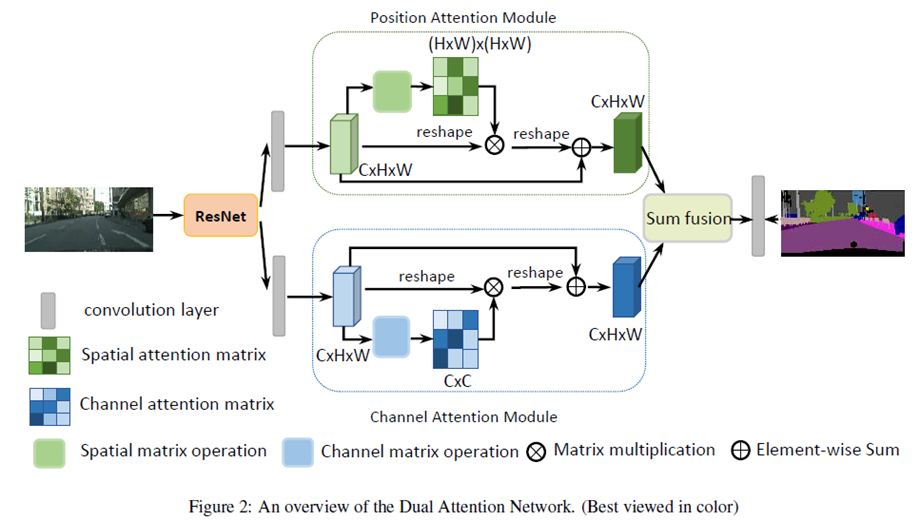

In [11]:
class DANet(ResNet50):
    r"""Pyramid Scene Parsing Network

    Parameters
    ----------
    nclass : int
        Number of categories for the training dataset.
    backbone : string
        Pre-trained dilated backbone network type (default:'resnet50'; 'resnet50',
        'resnet101' or 'resnet152').
    norm_layer : object
        Normalization layer used in backbone network (default: :class:`mxnet.gluon.nn.BatchNorm`;
        for Synchronized Cross-GPU BachNormalization).
    aux : bool
        Auxiliary loss.
    Reference:
        Jun Fu, Jing Liu, Haijie Tian, Yong Li, Yongjun Bao, Zhiwei Fang,and Hanqing Lu.
        "Dual Attention Network for Scene Segmentation." *CVPR*, 2019
    """

    def __init__(self, nclass, aux=True, **kwargs):
        super(DANet, self).__init__(nclass)
        self.head = _DAHead(2048, nclass, aux, **kwargs)
        self.aux = True
        self.__setattr__('exclusive', ['head'])

    def forward(self, x):
        size = x.size()[2:]
        print('x using size:', size)
        # base_forward : resnet50
        feature_map,_ = self.base_forward(x);print('resnet50 output feature map shape:',feature_map[0].shape)
        c3,c4 = feature_map[2],feature_map[3];print("c3 shape:", c3.shape);print("c4 shape:",c4.shape)
        
        outputs = []
        x = self.head(c4);print("x[0] shape:",x[0].shape)
        # x[0](입력) ; [2,19,30,30] / size(출력) : [480, 480] / align_corners=True : 모서리 픽셀의 값을 유지하면서 중심점을 기준으로 정렬
        x0 = F.interpolate(x[0], size, mode='bilinear', align_corners=True);print("bilinear interpolate shape:",x0.shape)
        outputs.append(x0)

        #if self.aux:
            #print('x[1]:{}'.format(x[1].shape))
#             x1 = F.interpolate(x[1], size, mode='bilinear', align_corners=True)
#             x2 = F.interpolate(x[2], size, mode='bilinear', align_corners=True)
#             outputs.append(x1)
#             outputs.append(x2)
        return outputs


In [12]:
def get_danet( backbone='resnet50', pretrained_base=True, **kwargs):
    cityspaces_numclass = 19
    model = DANet(cityspaces_numclass, backbone=backbone, pretrained_base=pretrained_base, **kwargs)
    return model

## test

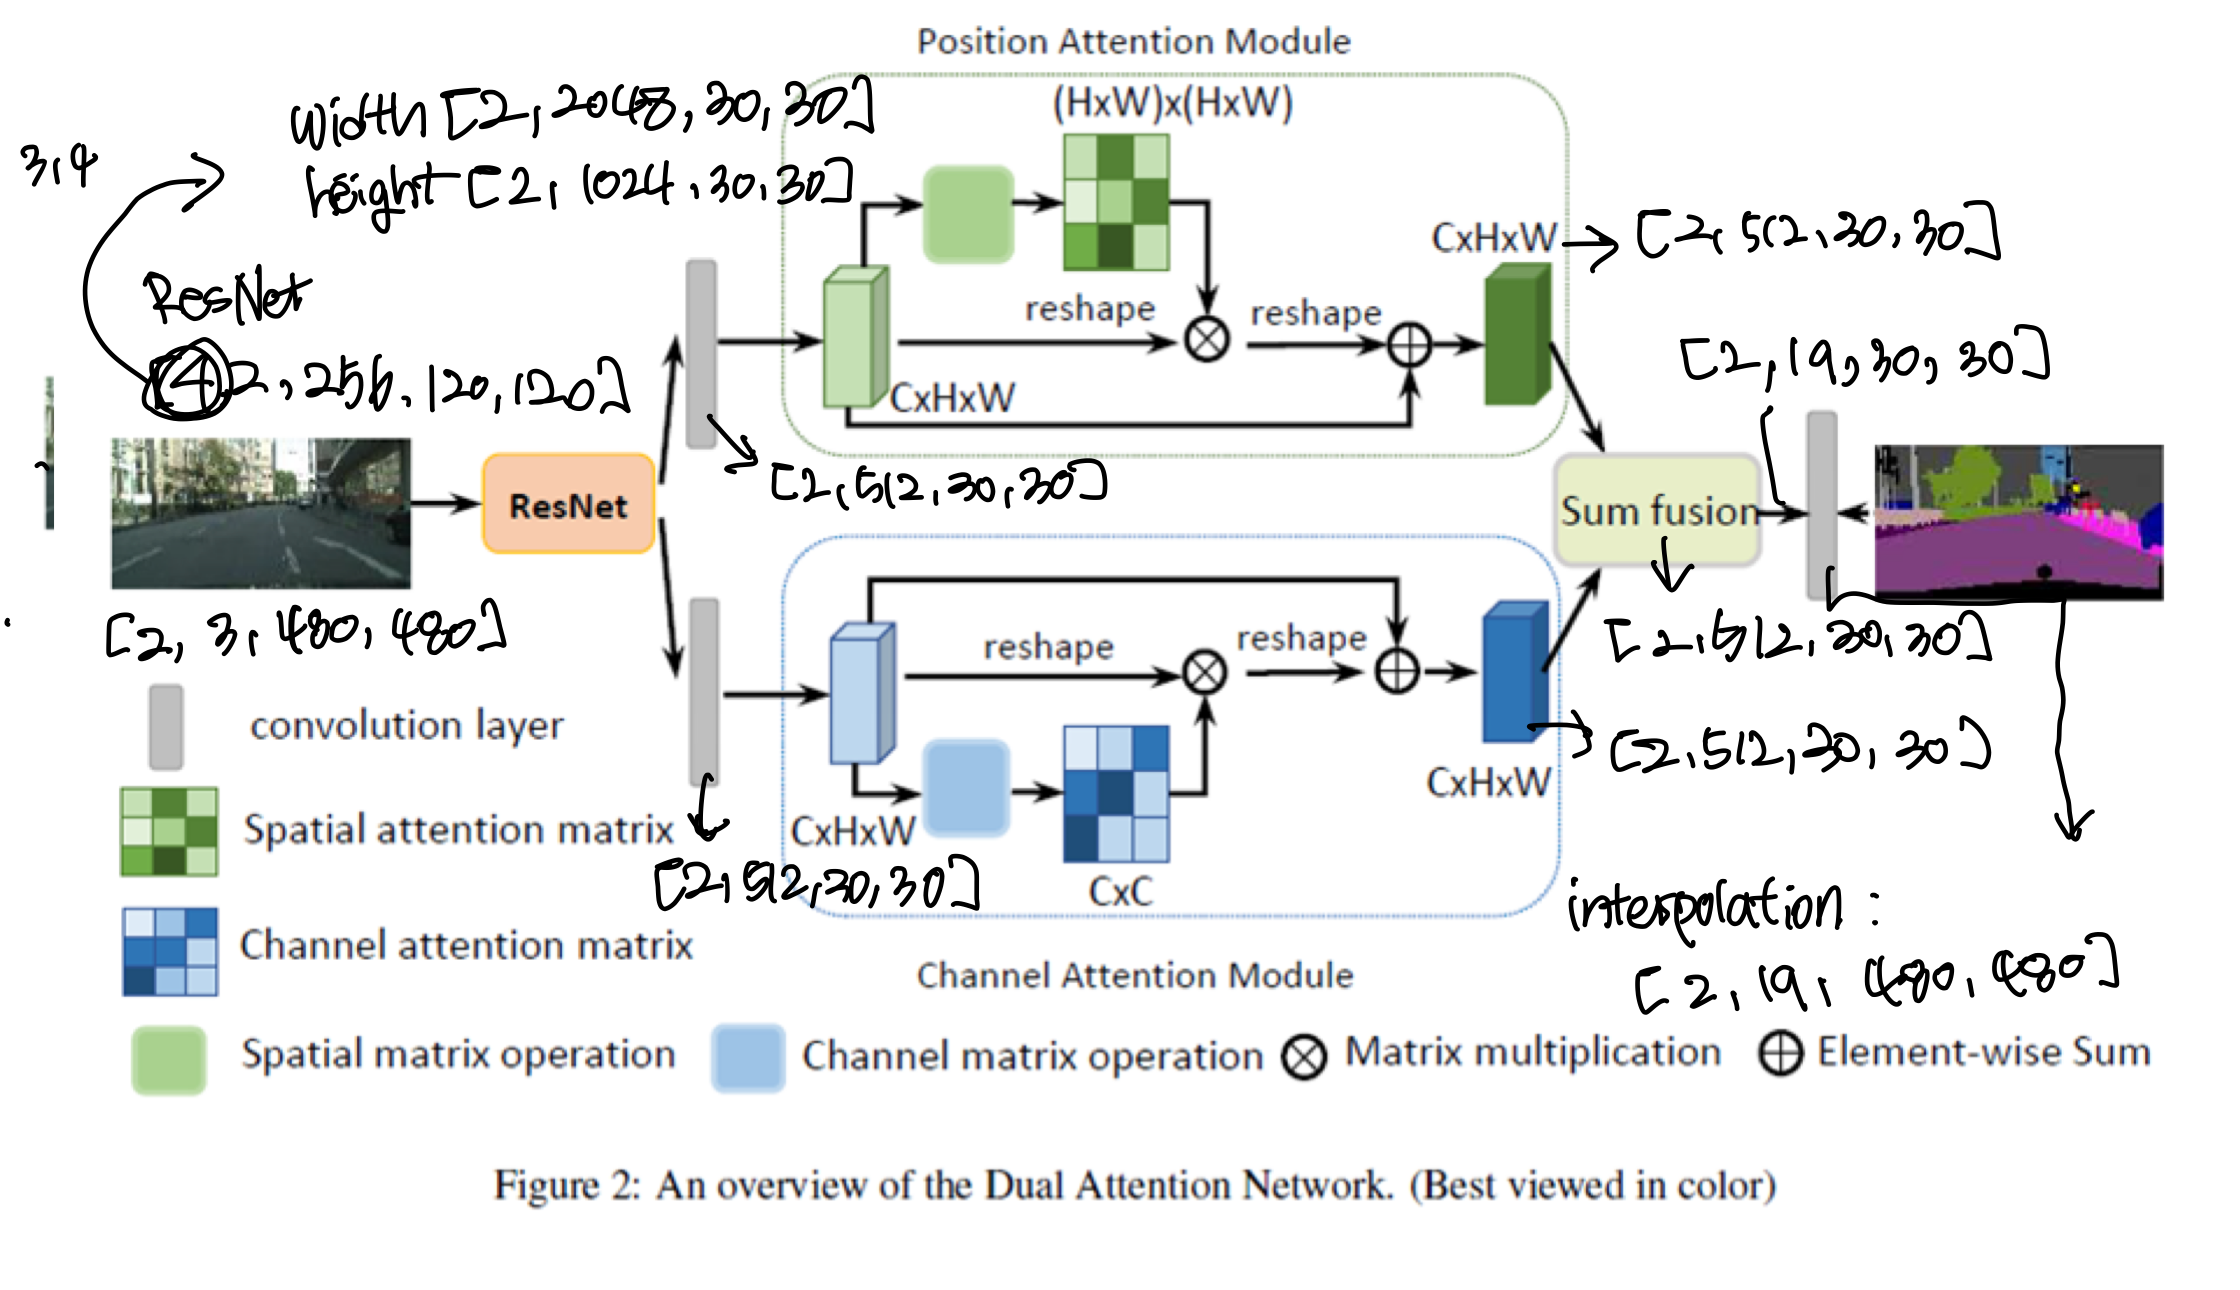

In [138]:
img = torch.randn(2, 3, 480, 480) #2장 / 480 * 480 * 3(RGB)
print('input(x) shape:', img.shape)
model = get_danet()
outputs = model(img)
#print(len(outputs))

input(x) shape: torch.Size([2, 3, 480, 480])
x using size: torch.Size([480, 480])
resnet50 conv1 shape: torch.Size([2, 64, 240, 240])
resnet50 bn1 shape: torch.Size([2, 64, 240, 240])
resnet50 relu shape: torch.Size([2, 64, 240, 240])
resnet50 maxpool shape: torch.Size([2, 64, 120, 120])
feature map len: 4
resnet50 output feature map shape: torch.Size([2, 256, 120, 120])
c3 shape: torch.Size([2, 1024, 30, 30])
c4 shape: torch.Size([2, 2048, 30, 30])
feat_p conv_p1 shape: torch.Size([2, 512, 30, 30])
feat_p pam shape: torch.Size([2, 512, 30, 30])
feat_p conv_p2 shape: torch.Size([2, 512, 30, 30])
feat_c conv_p1 shape: torch.Size([2, 512, 30, 30])
feat_c cam shape: torch.Size([2, 512, 30, 30])
feat_c conv_c2 shape: torch.Size([2, 512, 30, 30])
feat_fusion shape: torch.Size([2, 512, 30, 30])
fusion_out shape: torch.Size([2, 19, 30, 30])
outputs len: 1
c4 head[0] shape: torch.Size([2, 19, 30, 30])
bilinear interpolate shape: torch.Size([2, 19, 480, 480])


In [14]:
img = torch.randn(10, 3, 480, 480) #10장 / 480 * 480 * 3(RGB)
print('input(x) shape:', img.shape)
model = get_danet()
outputs = model(img)
#print(len(outputs))

input(x) shape: torch.Size([10, 3, 480, 480])
x using size: torch.Size([480, 480])
resnet50 conv1 shape: torch.Size([10, 64, 240, 240])
resnet50 bn1 shape: torch.Size([10, 64, 240, 240])
resnet50 relu shape: torch.Size([10, 64, 240, 240])
resnet50 maxpool shape: torch.Size([10, 64, 120, 120])
feature map len: 4
resnet50 output feature map shape: torch.Size([10, 256, 120, 120])
c3 shape: torch.Size([10, 1024, 30, 30])
c4 shape: torch.Size([10, 2048, 30, 30])
feat_p conv_p1 shape: torch.Size([10, 512, 30, 30])
feat_p pam shape: torch.Size([10, 512, 30, 30])
feat_p conv_p2 shape: torch.Size([10, 512, 30, 30])
feat_c conv_p1 shape: torch.Size([10, 512, 30, 30])
feat_c cam shape: torch.Size([10, 512, 30, 30])
feat_c conv_c2 shape: torch.Size([10, 512, 30, 30])
feat_fusion shape: torch.Size([10, 512, 30, 30])
fusion_out shape: torch.Size([10, 19, 30, 30])
outputs len: 1
c4 head[0] shape: torch.Size([10, 19, 30, 30])
bilinear interpolate shape: torch.Size([10, 19, 480, 480])
